# Volume 3: K-Means Clustering.
    Everett Bergeson
    <Class>
    <Date>

In [306]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg as la
from sklearn.cluster import KMeans
from imageio import imread, imsave
%matplotlib inline

In [272]:
plt.rcParams["figure.dpi"] = 200

## Problem 1

Write a `KMeans` class for doing basic $k$-means clustering.
Implement the following methods, following `sklearn` class conventions.
1. `__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

2. `fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.
Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.
Return `self` after completing this process.

3. `predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$th entry indicates which cluster center the $i$th row of $X$ is closest to.

Test your class on the iris data set (`sklean.datasets.load_iris()`) after reducing the data to two principal components (with `sklearn.decomposition.PCA`).
Plot the data, coloring by cluster. It should look similar to the graphs in the lab.

In [354]:
class KMeans:
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, p=2, normalize=False):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
            p (float): The norm to use
            normalize (bool): Whether to normalize the centers at each step
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.p = p
        self.normalize = normalize
    
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        rows = [i for i in range(len(X))]
        random_inds = np.random.choice(rows, self.n_clusters)
        centers = X[random_inds]
        
        # Compute which cluster each data point belongs to
        distances = []
        for x in X:
            distances.append([la.norm(x - j, ord=self.p) for j in centers])
        cluster_inds = np.argmin(distances, axis=1)

        # Calculate the mean of each of the new clusters
        means = []
        for j in range(self.n_clusters):
            cluster = X[cluster_inds == j]
            means.append(np.mean(cluster, axis=0))
                
        # Repeat this process max_iter times or until means converge
        for i in range(0, self.max_iter):
            distances = []
            for x in X:
                distances.append([la.norm(x - j, ord=self.p) for j in means])
            cluster_inds = np.argmin(distances, axis=1)
        
            new_means = []
            for j in range(self.n_clusters):
                cluster = X[cluster_inds == j]
                mean = np.mean(cluster, axis=0)
                if self.normalize:
                    new_means.append(mean / la.norm(mean))
                else:
                    new_means.append(mean)
                    
            # Check for convergence
            diff = abs(np.array(new_means) - np.array(means))
            if (diff < self.tol).all():
                break
                
            # Otherwise keep going
            means = new_means
                
        
        self.means = np.array(means)
        return self
    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters-1 for each entry of X.
        """
        distances = []
        for x in X:
            distances.append([la.norm(x - j, ord=self.p) for j in self.means])
        return np.argmin(distances, axis=1)
            
    
    def fit_predict(self, X, y=None):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)

In [274]:
#run this cell to get the iris data
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = PCA(n_components=2).fit_transform(iris.data)

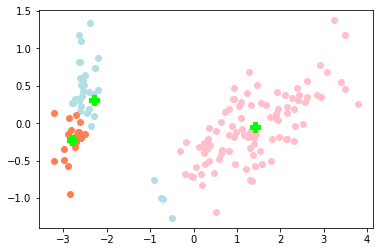

In [355]:
k = 3

clf = KMeans(k, p=np.inf)
preds = clf.fit_predict(iris_data)

colors = ['powderblue', 'pink', 'coral']
for i in range(k):
    clust = iris_data[preds == i]
    plt.scatter(clust[:,0], clust[:,1], c=colors[i])
    
plt.scatter(clf.means[:,0], clf.means[:,1], marker="P", s=100, c='lime')
plt.show()

## Problem 2

Modify `KMeansfit()` to take in a paramter `p` which gives us the norm to be used. 

Import and parse the Sacramento housing data.
1. Use your `KMeans` class with a chosen `norm` on the housing data, let n=12.
2. Experiment with different norms.
3. Plot the data, coloring by cluster.
Also mark the cluster centers.
In a Markdown cell explain which norm is best for decreasing the longest distance to farthest home.

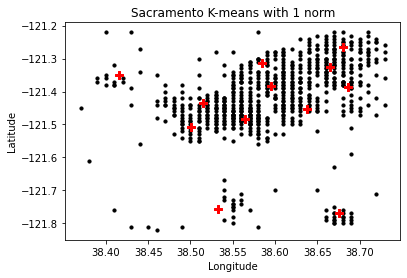

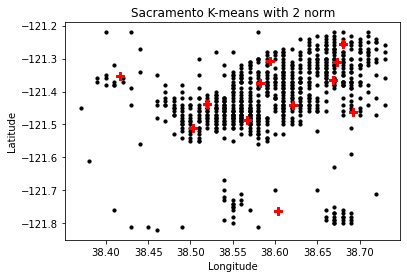

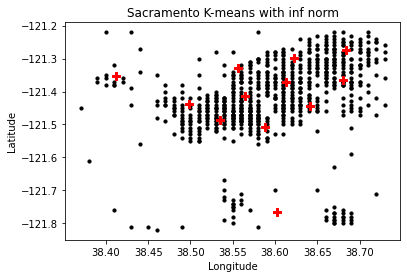

In [359]:
k = 12
X_total = np.load("sacramento.npy")
X = X_total[:, 6:]
# print(X.isna())

for p in [1, 2, np.inf]:
    clf = KMeans(k, p=p)
    preds = clf.fit_predict(X)

    for i in range(k):
        clust = X[preds == i]
        plt.scatter(clust[:,0], clust[:,1], c='black', s=10)

    plt.scatter(clf.means[:,0], clf.means[:,1], marker="P", s=50, c='red')
    plt.title("Sacramento K-means with {} norm".format(p))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

The 1-norm keeps the maximum distance small and makes the most sense in this scenario because streets are usually at 90 degree angles.

## Problem 3

Modify `KMeans.fit()` so that if `normalize` is `True`, the cluster centers are normalized at each iteration.

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
1. Convert longitude and latitude to radians, then to spherical coordinates.
(Hint: `np.deg2rad()` may be helpful.)
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use your `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.
5. Plot the data, coloring by cluster.
Also mark the cluster centers.

In [291]:
k = 15
X = np.load("earthquake_coordinates.npy")


X_rad = np.deg2rad(X)

sig = X_rad[:, 0]
phi = np.pi/2 - X_rad[:, 1]

x_spher = np.sin(phi) * np.cos(sig)
y_spher = np.sin(phi) * np.sin(sig)
z_spher = np.cos(phi)

sphere = np.array([[x, y, z] for x, y, z in zip(x_spher, y_spher, z_spher)])

k = 15
clf = KMeans(k, normalize=True)
preds = clf.fit_predict(sphere)

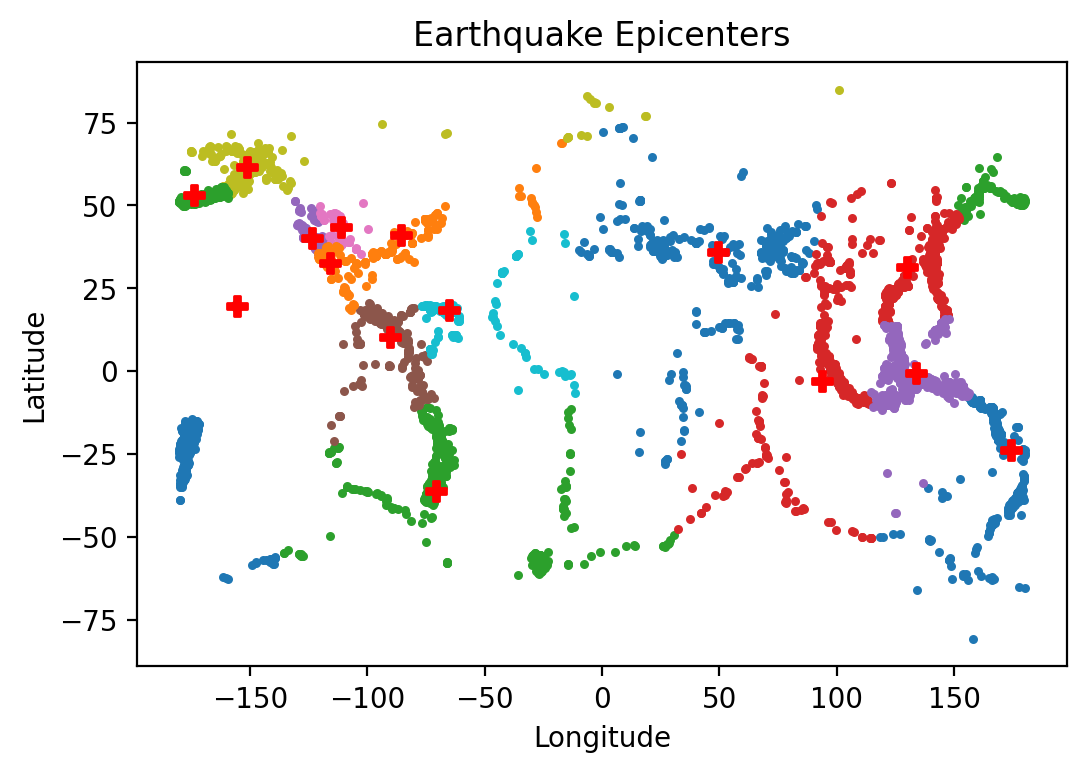

In [292]:
for i in range(k):
    clust = X[preds == i]
    plt.scatter(clust[:,0], clust[:,1], s=5)

x_center = clf.means[:,0]
y_center = clf.means[:,1]
z_center = clf.means[:,2]

phi = np.arccos(z_center)
sig = np.arctan2(y_center, x_center)

lon = sig * 180 / np.pi
lat = 90 - (phi * 180 / np.pi)
plt.scatter(lon, lat, marker="P", s=50, c='red')

# plt.scatter(clf.means[:,0], clf.means[:,1], marker="P", s=50, c='red')

plt.title("Earthquake Epicenters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Problem 4

Write a function that accepts an image array (of shape $(m,n,3)$), an integer number of clusters $k$, and an integer number of samples $S$.
Reshape the image so that each row represents a single pixel.
Choose $S$ pixels to train a $k$-means model on with $k$ clusters.
Make a copy of the original picture where each pixel has the same color as its cluster center.
Return the new image.
For this problem, you may use `sklearn.cluster.KMeans` instead of your `KMeans` class.

Test your function on some of the provided NASA images.

1328640
2069003


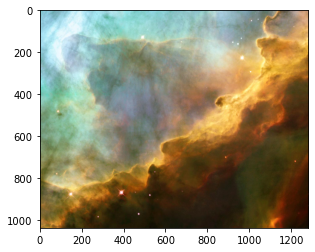

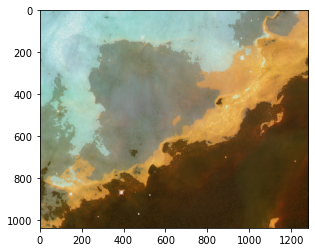

In [352]:

def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    flat = im.flatten().reshape(-1, 3)
    print(len(flat))
    sample_inds = np.random.choice(np.arange(len(flat)), n_samples)
    sample = flat[sample_inds]

    kmeans = KMeans(n_clusters=n_clusters).fit(sample)
    clusters = kmeans.predict(sample)
    centers = kmeans.cluster_centers_
    for i, center in enumerate(centers):
        flat[sample_inds[clusters == i]] = center
        
    
    return flat.reshape(im.shape)
    
picture = imread('nasa/omega_nebula.jpg')
new_pic = quantize_image(picture, 4, 1000000)
print(len(picture[picture != new_pic]))
plt.imshow(picture)
plt.show()
plt.imshow(new_pic)
plt.show()